# coverageAndTails_wFlairAssignments.ipynb
## Marcus Viscardi,    March 07, 2023

### Pulling it ALL together
So the goal here is going to be to produce a singular plot 
that contains the three coverage sets (NMD targ, not targ, 
and ambiguous) AND a paired tail CDF. This will probably 
require a few things:
1. The data wrangling from the tail plot and isoform plot loops in [isoformsFromFLAIR.ipynb](file:///data16/marcus/scripts/nanoporePipelineScripts/fourLibrary5TERA/isoformsFromFLAIR.ipynb)
2. Holding onto reads that failed that FLAIR assignment, then calling those ambiguous(?)
3. Some crazy matplotlib gridspec layout setup

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sea
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from itertools import product
from pathlib import Path
import sys
sys.path.insert(0, '/data16/marcus/scripts/nanoporePipelineScripts')
import nanoporePipelineCommon as npCommon
from nanoporeReadPlotting.finalizingReadAndCoveragePlotting_matplotlib import plot_reads, coverage_plotting_5tera

# At the isoform edge position we can differentiate cleavage species' parent isoform, left of which, we have enough info to differentiate between the NMD sensitive or insensitive isoforms!
# I manually identified that same isoform edge information for the following genes:
TARGETS_AND_ISOEDGE_DICT = {"rpl-30": [10_436_409, 'left', ['Y106G6H.3c.1']],
                            "rpl-26": [8_603_272, 'left', ['F28C6.7b.1']],
                            "rpl-3": [3_868_327, 'left', ['F13B10.2b']],
                            "rpl-1": [2_876_019, 'right', ['Y71F9AL.13b.4', 'Y71F9AL.13b.2']],
                            "rpl-12": [13_240_023, 'right', ['JC8.3c.2', 'JC8.3b']],
                            "ubl-1": [3_068_573, 'left', ['H06I04.4b.1']],
                            "rps-22": [1_950_996, 'left', ['F53A3.3b.1']],
                            # New as of 3/21/23:
                            "odc-1": [6_898_538, 'right', ['K11C4.4.1']],  # This analysis isn't quite the same... b/c only 1 isoform
                            # "rsp-1": [0, '', ['W02B12.3b.2']],  # Unsure on this one, TODO: look into this!
                            "hel-1": [8_327_695, 'right', ['C26D10.2b']],
                            "K08D12.3": [1_710_405, 'left', ['K08D12.3b.1']],  # mis-annotation here, but nice example
                            "aly-3": [12_124_246, 'left', ['M18.7b']],
                            }
CONVERSION_DICT = {"xrn-1-5tera": "oldN2",
                   "xrn-1-5tera-smg-6": "oldS6",
                   "5tera_xrn-1-KD_wt": "newN2",
                   "5tera_xrn-1-KD_wt_rerun": "newerN2",
                   "5tera_xrn-1-KD_smg-6_rerun": "newerS6",
                   "5tera_xrn-1-KD_smg-5": "newS5",
                   "5tera_xrn-1-KD_smg-6": "newS6",
                   "5tera_xrn-1-KD_smg-7": "newS7",
                   "sPM57": "sPM57",
                   "sPM58": "sPM58",
                   }
REV_CONVERSION_DICT = {val: key for key, val in CONVERSION_DICT.items()}
LIB_NAMES = list(REV_CONVERSION_DICT.keys())
print(f"Finished imports at: {npCommon.get_dt(for_print=True)}")

Finished imports at: 04/03/23 @ 04:38:48 PM


# Loading up flair and featureCounts gene assignments

Plan is to:
1. Load the mergedOnReads files for libraries (just oldN2 to start)
2. Load flair outputs from the *isoform.read.map.txt file - this will need some parsing (see this [link](https://stackoverflow.com/a/63983021/13316742))
3. Load preparsed gtf to add extra bits of info to flair outputs
4. Merge flair & gtf, then that with mergedOnReads. Be very specific to do a left merge - b/c I need all the stuff from the mergedOnReads for sure (tails, cigars, etc.)


After a first pass there are some edge cases that don't seem great.
* A fairly low portion of reads have mismatched assignments between FLAIR and ReadAssign
* MOST of these are actually just failures of one system or the other! I can probably just use the successful one for and overwrite the other. Or make a new column rather than overwrite.
* There are some reads where both are assigned, but they differ! Annoying, right now I am not sure what to do with these...

For now, lets write something to get the best assignment between the two.
1. If they match, just grab one.
2. If they don't match: See if one failed, then just grab the other one.
3. If they don't match and both succeeded: ***(FOR NOW)*** don't trust FLAIR, b/c the actual alignment I am plotting is from the genomic alignment!

Here we can see what's happening! Most of the reads actually only have one assignment. There are some reads that don't match, but that's the smallest population. There are also some reads that didn't get assigned by either!
![image](./output_files/assignment_plots/230308_assignmentsUpsetPlots_newN2.png)
You can also see a very small edge case, where FLAIR makes an assignment, but that gene isn't on the same chromosome as what the read mapped to! These are likely homology issues? It's such a small case here that I think we should just drop those reads. *(We can revisit later if interested...)*

In [2]:
def load_flair_and_reads(lib_key: str, print_stats=True, path_to_dir_for_assignment_plot=None) -> pd.DataFrame:
    def _pick_correct_gene_assignment(row):
        flair_assignment = row['gene_name_fromFlair']
        flair_biotype = row['gene_biotype_fromFlair']
        flair_id = row['gene_id_fromFlair']
        flair_chr = row['chr_id_fromFlair']
        flair_txn_id = row['transcript_id']
        
        gene_assignment = row['gene_name_fromReads']
        gene_biotype = row['gene_biotype_fromReads']
        gene_id = row['gene_id_fromReads']
        gene_chr = row['chr_id']
        
        if flair_assignment == gene_assignment:
            return flair_id, flair_assignment, flair_biotype, flair_txn_id, 'match'
        elif gene_assignment and not flair_assignment:
            return gene_id, gene_assignment, gene_biotype, None, 'read_flair-failed'
        elif flair_assignment and not gene_assignment:  # Issue here b/c flair assignment is a Nan float... not a Nonetype
            if flair_chr == gene_chr:
                return flair_id, flair_assignment, flair_biotype, flair_txn_id, 'flair_read-failed'
            else:
                return None, None, None, None, 'failed_read-failed_flair-vs-read-chr-mismatch'
        elif flair_assignment and gene_assignment:
            return gene_id, gene_assignment, gene_biotype, None, 'read_flair-vs-read-mismatch'
        else:
            return None, None, None, None, 'failed_no-assignment'
    gtf_df = pd.read_parquet("/data16/marcus/genomes/elegansRelease100/Caenorhabditis_elegans.WBcel235.100.gtf.parquet")
    transcript_gtf_df = gtf_df.query("feature == 'transcript'")[['chr', 'transcript_id', 'gene_id', 'gene_name', 'gene_biotype', 'transcript_biotype']]
    transcript_gtf_df.rename(columns={'chr': 'chr_id'}, inplace=True)
    gene_gtf_df = gtf_df.query("feature == 'gene'")[['gene_id', 'gene_name', 'gene_biotype']]
    
    reads_df = pd.read_parquet(npCommon.pick_lib_return_path(lib_key, file_midfix='_mergedOnReads', file_suffix='.parquet'))
    reads_df = reads_df.merge(gene_gtf_df, how='left', on=['gene_id', 'gene_name']).set_index('read_id')
    
    
    flair_wide_df = pd.read_table(npCommon.pick_lib_return_path(lib_key, output_dir_folder="flair", file_midfix='isoform.read.map', file_suffix='.txt'), sep='\t', names=['transcript_id', 'read_ids'])
    flair_wide_df['read_id'] = flair_wide_df.read_ids.str.split(',')
    flair_df = flair_wide_df.explode('read_id').reset_index(drop=True)[['read_id', 'transcript_id']]
    flair_df = flair_df.merge(transcript_gtf_df, how='left', on='transcript_id').set_index('read_id')
    
    reads_df['in_reads_df'] = True
    flair_df['in_flair_df'] = True
    
    l_merge_df = pd.merge(reads_df, flair_df, how='left',
                          on='read_id',
                          suffixes=('_fromReads', '_fromFlair'))
    l_merge_df.in_flair_df.fillna(False, inplace=True)
    l_merge_df.in_reads_df.fillna(False, inplace=True)
    
    o_merge_df = pd.merge(reads_df, flair_df, how='outer',
                          on='read_id',
                          suffixes=('_fromReads', '_fromFlair'))
    if print_stats:
        print(f"\n"
              f"Total FLAIR assigned reads:       {flair_df.shape[0]:>20,}\n"
              f"Total nonFLAIR assigned reads:    {reads_df.shape[0]:>20,}\n"
              f"Total reads after merge:          {l_merge_df.shape[0]:>20,}\n"
              f"Reads from FLAIR that didnt make it:{o_merge_df.shape[0] - l_merge_df.shape[0]:>18,}\n"
              f"Reads not assigned by FLAIR:      {l_merge_df.in_flair_df.value_counts()[False]:>20,}"
              f" <-- These are the ambiguous reads(?)\n",
              )
    
    l_merge_df.rename(columns={'chr_id_fromReads': 'chr_id'}, inplace=True)
    l_merge_df['lib'] = CONVERSION_DICT[lib_key]
    
    if isinstance(path_to_dir_for_assignment_plot, str):
        new_df = pd.DataFrame()
        new_df['matched_assignment'] = l_merge_df.gene_name_fromFlair == l_merge_df.gene_name_fromReads
        new_df['assigned_by_FLAIR'] = ~l_merge_df.gene_name_fromFlair.isna()
        new_df['assigned_by_READS'] = ~l_merge_df.gene_name_fromReads.isna()
        
        new_df['matched_chrs'] = l_merge_df.chr_id == l_merge_df.chr_id_fromFlair
        
        npCommon.boolDF_to_upsetPlot(new_df,
                                     show_percentages=False,
                                     file_name=f"{path_to_dir_for_assignment_plot}/{npCommon.get_dt()}_assignmentsUpsetPlots_{CONVERSION_DICT[lib_key]}.png",
                                     )
    
    cols_to_drop = ('gene_name_fromFlair',
                    'gene_biotype_fromFlair',
                    'gene_id_fromFlair',
                    'chr_id_fromFlair',
                    'transcript_id',
                    'gene_name_fromReads',
                    'gene_biotype_fromReads',
                    'gene_id_fromReads',
                    'transcript_biotype',
                    'in_reads_df',
                    'in_flair_df',
                    'chr',
                    )
    
    l_merge_final_columns = [col for col in l_merge_df.columns.tolist() if col not in cols_to_drop]
    new_assignment_columns = ['gene_id', 'gene_name', 'gene_biotype', 'transcript_id', 'assignment_tag']
    l_merge_final_columns += new_assignment_columns
    
    l_merge_df = l_merge_df.where(pd.notnull(l_merge_df), None)
    
    if print_stats:
        tqdm.pandas(desc='Correcting gene/transcript assignments')
        l_merge_df[new_assignment_columns] = l_merge_df.progress_apply(_pick_correct_gene_assignment, axis=1, result_type='expand')
    else:
        l_merge_df[new_assignment_columns] = l_merge_df.apply(_pick_correct_gene_assignment, axis=1, result_type='expand')
    
    
    return l_merge_df[l_merge_final_columns]

def long_to_wide(input_df, wide_target_cols=['gene_rpm'], expand_col='lib', fillna=True) -> pd.DataFrame:
    w = input_df[wide_target_cols].unstack(level=expand_col)
    w.columns = w.columns.map('{0[0]}_{0[1]}'.format)
    if fillna:
        return w.reset_index().fillna(0)
    else:
        return w.reset_index()

Could not find preprocessed files matching these libs: newN2/newS5/newS6/newerN2/newerS6/oldN2/oldS6
Going to create new ones from scratch! This will take longer.
Looking for file for 5tera_xrn-1-KD_wt, at /data16/marcus/working/221216_nanoporeRun_totalRNA_wt_xrn-1-KD_5TERA/output_dir/merge_files/*_mergedOnReads.parquet... File Found.
Looking for file for 5tera_xrn-1-KD_wt, at /data16/marcus/working/221216_nanoporeRun_totalRNA_wt_xrn-1-KD_5TERA/output_dir/flair/*isoform.read.map.txt... File Found.

Total FLAIR assigned reads:                     96,902
Total nonFLAIR assigned reads:                 134,042
Total reads after merge:                       134,042
Reads from FLAIR that didnt make it:             1,594
Reads not assigned by FLAIR:                    38,734 <-- These are the ambiguous reads(?)



Correcting gene/transcript assignments:   0%|          | 0/134042 [00:00<?, ?it/s]

Looking for file for 5tera_xrn-1-KD_smg-5, at /data16/marcus/working/221216_nanoporeRun_totalRNA_smg-5_xrn-1-KD_5TERA/output_dir/merge_files/*_mergedOnReads.parquet... File Found.
Looking for file for 5tera_xrn-1-KD_smg-5, at /data16/marcus/working/221216_nanoporeRun_totalRNA_smg-5_xrn-1-KD_5TERA/output_dir/flair/*isoform.read.map.txt... File Found.

Total FLAIR assigned reads:                    123,314
Total nonFLAIR assigned reads:                 172,837
Total reads after merge:                       172,837
Reads from FLAIR that didnt make it:             1,566
Reads not assigned by FLAIR:                    51,089 <-- These are the ambiguous reads(?)



Correcting gene/transcript assignments:   0%|          | 0/172837 [00:00<?, ?it/s]

Looking for file for 5tera_xrn-1-KD_smg-6, at /data16/marcus/working/221216_nanoporeRun_totalRNA_smg-6_xrn-1-KD_5TERA/output_dir/merge_files/*_mergedOnReads.parquet... File Found.
Looking for file for 5tera_xrn-1-KD_smg-6, at /data16/marcus/working/221216_nanoporeRun_totalRNA_smg-6_xrn-1-KD_5TERA/output_dir/flair/*isoform.read.map.txt... File Found.

Total FLAIR assigned reads:                     61,608
Total nonFLAIR assigned reads:                  87,379
Total reads after merge:                        87,379
Reads from FLAIR that didnt make it:             2,008
Reads not assigned by FLAIR:                    27,779 <-- These are the ambiguous reads(?)



Correcting gene/transcript assignments:   0%|          | 0/87379 [00:00<?, ?it/s]

Looking for file for 5tera_xrn-1-KD_wt_rerun, at /data16/marcus/working/230327_nanoporeRun_totalRNA_wt_xrn-1-KD_5TERA_rerun/output_dir/merge_files/*_mergedOnReads.parquet... File Found.
Looking for file for 5tera_xrn-1-KD_wt_rerun, at /data16/marcus/working/230327_nanoporeRun_totalRNA_wt_xrn-1-KD_5TERA_rerun/output_dir/flair/*isoform.read.map.txt... File Found.

Total FLAIR assigned reads:                    447,159
Total nonFLAIR assigned reads:               1,053,185
Total reads after merge:                     1,053,185
Reads from FLAIR that didnt make it:             3,266
Reads not assigned by FLAIR:                   609,292 <-- These are the ambiguous reads(?)



Correcting gene/transcript assignments:   0%|          | 0/1053185 [00:00<?, ?it/s]

Looking for file for 5tera_xrn-1-KD_smg-6_rerun, at /data16/marcus/working/230403_nanoporeRun_totalRNA_smg-6_xrn-1-KD_5TERA_rerun/output_dir/merge_files/*_mergedOnReads.parquet... File Found.
Looking for file for 5tera_xrn-1-KD_smg-6_rerun, at /data16/marcus/working/230403_nanoporeRun_totalRNA_smg-6_xrn-1-KD_5TERA_rerun/output_dir/flair/*isoform.read.map.txt... File Found.

Total FLAIR assigned reads:                    657,150
Total nonFLAIR assigned reads:               1,226,144
Total reads after merge:                     1,226,144
Reads from FLAIR that didnt make it:             4,231
Reads not assigned by FLAIR:                   573,225 <-- These are the ambiguous reads(?)



Correcting gene/transcript assignments:   0%|          | 0/1226144 [00:00<?, ?it/s]

Looking for file for xrn-1-5tera, at /data16/marcus/working/211118_nanoporeRun_totalRNA_5108_xrn-1-KD_5TERA/output_dir/merge_files/*_mergedOnReads.parquet... File Found.
Looking for file for xrn-1-5tera, at /data16/marcus/working/211118_nanoporeRun_totalRNA_5108_xrn-1-KD_5TERA/output_dir/flair/*isoform.read.map.txt... File Found.

Total FLAIR assigned reads:                    538,150
Total nonFLAIR assigned reads:                 701,680
Total reads after merge:                       701,680
Reads from FLAIR that didnt make it:             3,972
Reads not assigned by FLAIR:                   167,502 <-- These are the ambiguous reads(?)



Correcting gene/transcript assignments:   0%|          | 0/701680 [00:00<?, ?it/s]

Looking for file for xrn-1-5tera-smg-6, at /data16/marcus/working/211210_nanoporeRun_totalRNA_2102_xrn-1-KD_5TERA/output_dir/merge_files/*_mergedOnReads.parquet... File Found.
Looking for file for xrn-1-5tera-smg-6, at /data16/marcus/working/211210_nanoporeRun_totalRNA_2102_xrn-1-KD_5TERA/output_dir/flair/*isoform.read.map.txt... File Found.

Total FLAIR assigned reads:                    170,697
Total nonFLAIR assigned reads:                 236,286
Total reads after merge:                       236,286
Reads from FLAIR that didnt make it:             2,257
Reads not assigned by FLAIR:                    67,846 <-- These are the ambiguous reads(?)



Correcting gene/transcript assignments:   0%|          | 0/236286 [00:00<?, ?it/s]

Saving new parquets to speed up future runs.
Lib load done @ 04/03/23 @ 04:42:15 PM


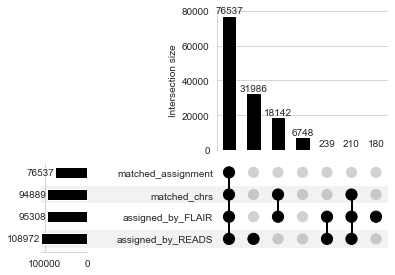

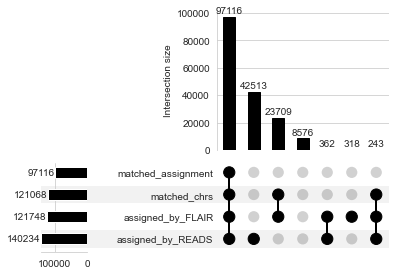

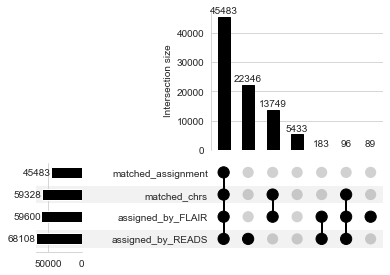

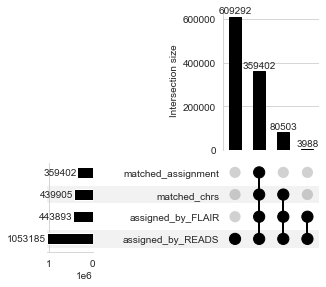

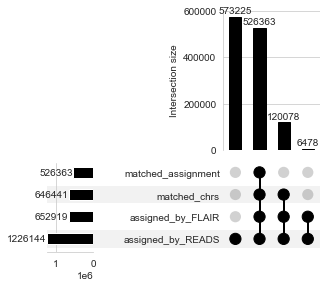

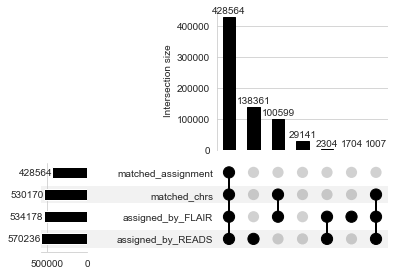

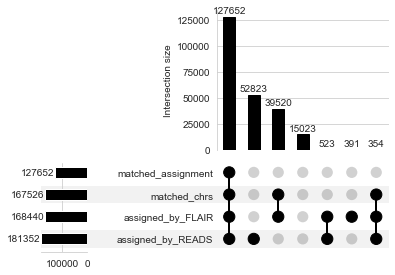

In [3]:
regenerate = False
print_per_lib_loading_stats = True
save_read_assignments_upset_dir = "./output_files/assignment_plots"  # Set to none if you don't want to make these plots

libs_to_load = sorted({
    "oldN2",
    "oldS6",
    "newN2",
    "newerN2",
    "newerS6",
    "newS5",
    "newS6",
    # "newS7",
    # "sPM57",
    # "sPM58",
    })
try:
    if regenerate:
        raise ValueError
    reads_df_raw_path = npCommon.find_newest_matching_file(f"./output_files/mega_merge_parquets/*_{'-'.join(libs_to_load)}_5TERA.reads_df.transcriptsAndGenes.parquet")
    print(f"Found preprocessed file at:\n\t{reads_df_raw_path}")
    reads_df_raw = pd.read_parquet(reads_df_raw_path)
except ValueError:
    print(f"Could not find preprocessed files matching these libs: {'/'.join(libs_to_load)}\n"
          f"Going to create new ones from scratch! This will take longer.")
    lib_dict = {}
    for library in libs_to_load:
        lib_dict[library] = load_flair_and_reads(REV_CONVERSION_DICT[library],
                                                 path_to_dir_for_assignment_plot=save_read_assignments_upset_dir,
                                                 print_stats=print_per_lib_loading_stats,
                                                 )
    if len(libs_to_load) == 1:
        reads_df_raw = lib_dict[library]
    else:
        reads_df_raw = pd.concat(list(lib_dict.values()))
    
    print(f"Saving new parquets to speed up future runs.")
    reads_df_raw.to_parquet(f"./output_files/mega_merge_parquets/{npCommon.get_dt()}_{'-'.join(libs_to_load)}_5TERA.reads_df.transcriptsAndGenes.parquet")

print(f"Lib load done @ {npCommon.get_dt(for_print=True)}")

# Now lets plot this thing!!

In [4]:
def plots_tails_ecdf(library_df, targeted_gene,
                     lib_target,
                     save_dir=f"./output_files/isoform_plots/NMD_and_Adapted_tailPlots",
                     given_ax=None,
                     log_xaxis=True,
                     ):
    palette = {"NMD'ed: +  t5: -": "darkred",
               "NMD'ed: +  t5: +": "red", 
               "NMD'ed: -  t5: -": "darkblue",
               "NMD'ed: -  t5: +": "blue",
               "NMD'ed: ~  t5: -": "darkgray",
               "NMD'ed: ~  t5: +": "gray"}
    
    if given_ax:
        ax = given_ax
    else:
        _, ax = plt.subplots(figsize=(8, 6))
    g = sea.ecdfplot(library_df.sort_values('NMD_and_t5'),
                     ax=ax,
                     x='polya_length',
                     hue='NMD_and_t5',
                     palette=palette,
                     log_scale=log_xaxis,
                     )
    # Change the line styles:
    for i, line in enumerate(g.lines):
        if line.get_color().startswith("dark"):
            line.set_linestyle("-")
        else:
            line.set_linestyle("--")
    if not given_ax:
        plt.title(f"Tail lengths from {lib_target} for {targeted_gene}")
    if log_xaxis:
        ax.set_xbound(10, 200)
        ax.set_xticks([10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200])
        ax.set_xticklabels([10, 20, 30, 40, 50, None, 70, None, None, 100, 200])
    else:
        ax.set_xbound(-1, 200)
    # sea.move_legend(g, "lower right")
    ax.get_legend().remove()
    if not given_ax:
        plt.tight_layout()
    if isinstance(save_dir, str):
        save_dir = Path(save_dir)
        if not save_dir.exists():
            print(f"Making new directory at: {save_dir}")
            save_dir.mkdir()
        
        save_path = str(save_dir) + f"/{npCommon.get_dt()}_{targeted_gene}_{lib_target}_NMD-and-t5_tailLength.ecdf"
        if log_xaxis:
            save_path += ".logAxis"
        for file_type in ['.svg', '.png']:
            plt.savefig(save_path + file_type, dpi=300)
        plt.show()


def plots_tails_violin(library_df, targeted_gene,
                     lib_target,
                     save_dir=f"./output_files/isoform_plots/NMD_and_Adapted_tailPlots",
                     given_ax=None,
                     log_yaxis=True,
                     ):
    palette = {"NMD'ed: +  t5: -":"darkred",
               "NMD'ed: +  t5: +":"red", 
               "NMD'ed: -  t5: -":"darkblue",
               "NMD'ed: -  t5: +":"blue",
               "NMD'ed: ~  t5: -":"darkgray",
               "NMD'ed: ~  t5: +":"gray"}
    
    if given_ax:
        ax = given_ax
    else:
        _, ax = plt.subplots(figsize=(8, 6))
    g = sea.violinplot(library_df.sort_values('NMD_and_t5'),
                       ax=ax,
                       y='polya_length',
                       x='NMD_Sensitive_Isoform',
                       hue='t5',
                       # palette=palette,
                       cut=0,
                       split=True,
                       inner='stick',
                       )
    if not given_ax:
        plt.title(f"Tail lengths from {lib_target} for {targeted_gene}")
    if log_yaxis:
        ax.set_ybound(10, 200)
        ax.set_yticks([10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200])
        ax.set_yticklabels([10, 20, 30, 40, 50, None, 70, None, None, 100, 200])
    else:
        ax.set_ybound(-1, 200)
    # sea.move_legend(g, "lower right")
    # ax.get_legend().remove()
    if not given_ax:
        plt.tight_layout()
    if isinstance(save_dir, str):
        save_dir = Path(save_dir)
        if not save_dir.exists():
            print(f"Making new directory at: {save_dir}")
            save_dir.mkdir()
        
        save_path = str(save_dir) + f"/{npCommon.get_dt()}_{targeted_gene}_{lib_target}_NMD-and-t5_tailLength.violin"
        if log_yaxis:
            save_path += ".logAxis"
        for file_type in ['.svg', '.png']:
            plt.savefig(save_path + file_type, dpi=300)
        plt.show()


def plot_tails_and_coverage(df, target_gene, lib,
                            quiet=False, save_dir=None,
                            seaborn_context='talk',
                            log_tails=True,
                            ecdf_tails=True):
    sea.set_style("whitegrid")
    sea.set_context(seaborn_context)
    
    
    ### Process dataframe >>>
    df = df.query(f"lib == '{lib}'")
    
    try:
        iso_edge, left_or_right, NMD_sensitive_txns = TARGETS_AND_ISOEDGE_DICT[target_gene]
    except KeyError:
        raise KeyError(f"Currently only these genes have the necessary information for this full analysis:\n{list(TARGETS_AND_ISOEDGE_DICT.keys())}")
    
    if left_or_right == 'left':
        comparator = "<="
        anti_comparator = ">="
    elif left_or_right == 'right':
        comparator = ">="
        anti_comparator = "<="
    else:  # This is just to shut pycharm up
        comparator = None
        anti_comparator = None
    
    nmd_sensitive_genes_and_txns_dict = {potential_target_gene: NMD_sensitive_txns for potential_target_gene, (_, _, NMD_sensitive_txns) in TARGETS_AND_ISOEDGE_DICT.items()}
    df['NMD_Sensitive_Isoform'] = df['transcript_id'].isin(nmd_sensitive_genes_and_txns_dict[target_gene]).replace({True: '+', False: '-'})
    df.NMD_Sensitive_Isoform.mask(((df.t5 == '+') & (df.eval(f"chr_pos {anti_comparator} {iso_edge}"))), '~', inplace=True)
    df.NMD_Sensitive_Isoform.mask(df.transcript_id.isna(), '~', inplace=True)
    df['NMD_and_t5'] = df.apply(lambda row: f"NMD'ed: {str(row['NMD_Sensitive_Isoform'])}  t5: {row['t5']}", axis=1)
    ### <<< Process dataframe
    
    
    ### Build plot >>>
    single_nest = [
        ['target_adapted', 'tails'],
        ['target_unadapted', 'tails'],
        ['non_target_adapted', 'tails'],
        ['non_target_unadapted', 'tails'],
        ['ambiguous_adapted', 'tails'],
        ['ambiguous_unadapted', 'tails'],
        ['space_for_annotations', 'tails']
    ]
    fig, axd = plt.subplot_mosaic(single_nest,
                                  # layout="constrained",
                                  figsize=(15,7),
                                  height_ratios=(1,2,1,2,1,2,1), 
                                  width_ratios=(2,4))
    
    adapted_axes = [ax for name, ax in axd.items() if name.endswith('_adapted')]
    unadapted_axes = [ax for name, ax in axd.items() if name.endswith('_unadapted')]
    ### <<< Build plot
    
    
    ### Plot coverage >>>
    assignment_types_axes = []
    for assignment_type in ['target', 'non_target', 'ambiguous']:
        assignment_types_axes.append([ax for name, ax in axd.items() if name.startswith(assignment_type)])
    
    plot_colors = ('red', 'blue', 'gray')
    
    axes_iterator = zip(['+', '-', '~'], assignment_types_axes, plot_colors)
    for assignment, assignment_axes, plot_color in axes_iterator:  # Either two steps here or three (if ambiguous reads getting plotted!)
        print(f"Calculating coverage for NMD-({assignment}) isoform in {lib} library:")
        # print(lib_df.query(f"NMD_Sensitive_Isoform == '{target}'"))
        print(assignment, assignment_axes)
        coverage_plotting_5tera(df,
                                gene_name=target_gene,
                                provide_axes=assignment_axes,
                                rpm_normalize=True,
                                additional_plot_df_query=f"NMD_Sensitive_Isoform == '{assignment}'",
                                quiet=quiet,
                                adapted_color=plot_color,
                                unadapted_color='dark' + plot_color,
                                )
    
    adapted_axes[0].get_shared_y_axes().join(*adapted_axes)
    unadapted_axes[0].get_shared_y_axes().join(*unadapted_axes)
    
    for ax in adapted_axes + unadapted_axes:
        ax.yaxis.get_major_ticks()[1].label1.set_visible(False)
    
    ### <<< Plot coverage
    
    ### Plot tails >>>
    gene_df = df.query(f"gene_name == '{target_gene}'")
    if ecdf_tails:
        plots_tails_ecdf(gene_df, target_gene, lib,
                         given_ax=axd['tails'],
                         save_dir=None,
                         log_xaxis=log_tails,
                         )
    else:
        plots_tails_violin(gene_df, target_gene, lib,
                           given_ax=axd['tails'],
                           save_dir=None,
                           log_yaxis=log_tails)
    ### <<< Plot tails
    
    ### Final cleanup >>>
    annotation_ax = axd['space_for_annotations']
    annotation_ax.grid(False)
    annotation_ax.axis('off')
    annotation_ax.set_xticklabels([])
    annotation_ax.set_yticklabels([])
    plt.subplots_adjust(wspace=0.25, hspace=0.30)
    plt.suptitle(f'{target_gene} in {lib}')
    ### <<< Final cleanup
    
    ### Save plot >>>
    if isinstance(save_dir, str):
        save_dir = Path(save_dir)
        if not save_dir.exists():
            save_dir.mkdir()
        plot_file_name = f"{npCommon.get_dt()}_{target_gene}_{lib}_coverageAndTailsPlots"
        for file_type in ('.svg', '.png'):
            save_path = str(save_dir) + '/' + plot_file_name + file_type
            plt.savefig(save_path)
    else:
        plt.show()
    ### <<< Save plot
    return fig, axd

Calculating coverage for NMD-(+) isoform in oldN2 library:
+ [<AxesSubplot: label='target_adapted'>, <AxesSubplot: label='target_unadapted'>]
Calculating coverage for NMD-(-) isoform in oldN2 library:
- [<AxesSubplot: label='non_target_adapted'>, <AxesSubplot: label='non_target_unadapted'>]
Calculating coverage for NMD-(~) isoform in oldN2 library:
~ [<AxesSubplot: label='ambiguous_adapted'>, <AxesSubplot: label='ambiguous_unadapted'>]


/tmp/ipykernel_1812058/1251332572.py:188: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  adapted_axes[0].get_shared_y_axes().join(*adapted_axes)
/tmp/ipykernel_1812058/1251332572.py:189: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  unadapted_axes[0].get_shared_y_axes().join(*unadapted_axes)


Calculating coverage for NMD-(+) isoform in oldN2 library:
+ [<AxesSubplot: label='target_adapted'>, <AxesSubplot: label='target_unadapted'>]
Calculating coverage for NMD-(-) isoform in oldN2 library:
- [<AxesSubplot: label='non_target_adapted'>, <AxesSubplot: label='non_target_unadapted'>]
Calculating coverage for NMD-(~) isoform in oldN2 library:
~ [<AxesSubplot: label='ambiguous_adapted'>, <AxesSubplot: label='ambiguous_unadapted'>]


/tmp/ipykernel_1812058/1251332572.py:188: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  adapted_axes[0].get_shared_y_axes().join(*adapted_axes)
/tmp/ipykernel_1812058/1251332572.py:189: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  unadapted_axes[0].get_shared_y_axes().join(*unadapted_axes)


Calculating coverage for NMD-(+) isoform in oldN2 library:
+ [<AxesSubplot: label='target_adapted'>, <AxesSubplot: label='target_unadapted'>]
Calculating coverage for NMD-(-) isoform in oldN2 library:
- [<AxesSubplot: label='non_target_adapted'>, <AxesSubplot: label='non_target_unadapted'>]
Calculating coverage for NMD-(~) isoform in oldN2 library:
~ [<AxesSubplot: label='ambiguous_adapted'>, <AxesSubplot: label='ambiguous_unadapted'>]


/tmp/ipykernel_1812058/1251332572.py:188: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  adapted_axes[0].get_shared_y_axes().join(*adapted_axes)
/tmp/ipykernel_1812058/1251332572.py:189: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  unadapted_axes[0].get_shared_y_axes().join(*unadapted_axes)


Calculating coverage for NMD-(+) isoform in oldS6 library:
+ [<AxesSubplot: label='target_adapted'>, <AxesSubplot: label='target_unadapted'>]
Calculating coverage for NMD-(-) isoform in oldS6 library:
- [<AxesSubplot: label='non_target_adapted'>, <AxesSubplot: label='non_target_unadapted'>]
Calculating coverage for NMD-(~) isoform in oldS6 library:
~ [<AxesSubplot: label='ambiguous_adapted'>, <AxesSubplot: label='ambiguous_unadapted'>]


/tmp/ipykernel_1812058/1251332572.py:188: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  adapted_axes[0].get_shared_y_axes().join(*adapted_axes)
/tmp/ipykernel_1812058/1251332572.py:189: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  unadapted_axes[0].get_shared_y_axes().join(*unadapted_axes)


Calculating coverage for NMD-(+) isoform in oldS6 library:
+ [<AxesSubplot: label='target_adapted'>, <AxesSubplot: label='target_unadapted'>]
Calculating coverage for NMD-(-) isoform in oldS6 library:
- [<AxesSubplot: label='non_target_adapted'>, <AxesSubplot: label='non_target_unadapted'>]
Calculating coverage for NMD-(~) isoform in oldS6 library:
~ [<AxesSubplot: label='ambiguous_adapted'>, <AxesSubplot: label='ambiguous_unadapted'>]


/tmp/ipykernel_1812058/1251332572.py:188: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  adapted_axes[0].get_shared_y_axes().join(*adapted_axes)
/tmp/ipykernel_1812058/1251332572.py:189: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  unadapted_axes[0].get_shared_y_axes().join(*unadapted_axes)


Calculating coverage for NMD-(+) isoform in oldS6 library:
+ [<AxesSubplot: label='target_adapted'>, <AxesSubplot: label='target_unadapted'>]
Calculating coverage for NMD-(-) isoform in oldS6 library:
- [<AxesSubplot: label='non_target_adapted'>, <AxesSubplot: label='non_target_unadapted'>]
Calculating coverage for NMD-(~) isoform in oldS6 library:
~ [<AxesSubplot: label='ambiguous_adapted'>, <AxesSubplot: label='ambiguous_unadapted'>]


/tmp/ipykernel_1812058/1251332572.py:188: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  adapted_axes[0].get_shared_y_axes().join(*adapted_axes)
/tmp/ipykernel_1812058/1251332572.py:189: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  unadapted_axes[0].get_shared_y_axes().join(*unadapted_axes)


Calculating coverage for NMD-(+) isoform in newerN2 library:
+ [<AxesSubplot: label='target_adapted'>, <AxesSubplot: label='target_unadapted'>]
Calculating coverage for NMD-(-) isoform in newerN2 library:
- [<AxesSubplot: label='non_target_adapted'>, <AxesSubplot: label='non_target_unadapted'>]
Calculating coverage for NMD-(~) isoform in newerN2 library:
~ [<AxesSubplot: label='ambiguous_adapted'>, <AxesSubplot: label='ambiguous_unadapted'>]


/tmp/ipykernel_1812058/1251332572.py:188: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  adapted_axes[0].get_shared_y_axes().join(*adapted_axes)
/tmp/ipykernel_1812058/1251332572.py:189: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  unadapted_axes[0].get_shared_y_axes().join(*unadapted_axes)


Calculating coverage for NMD-(+) isoform in newerN2 library:
+ [<AxesSubplot: label='target_adapted'>, <AxesSubplot: label='target_unadapted'>]
Calculating coverage for NMD-(-) isoform in newerN2 library:
- [<AxesSubplot: label='non_target_adapted'>, <AxesSubplot: label='non_target_unadapted'>]
Calculating coverage for NMD-(~) isoform in newerN2 library:
~ [<AxesSubplot: label='ambiguous_adapted'>, <AxesSubplot: label='ambiguous_unadapted'>]


/tmp/ipykernel_1812058/1251332572.py:188: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  adapted_axes[0].get_shared_y_axes().join(*adapted_axes)
/tmp/ipykernel_1812058/1251332572.py:189: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  unadapted_axes[0].get_shared_y_axes().join(*unadapted_axes)


Calculating coverage for NMD-(+) isoform in newerN2 library:
+ [<AxesSubplot: label='target_adapted'>, <AxesSubplot: label='target_unadapted'>]
Calculating coverage for NMD-(-) isoform in newerN2 library:
- [<AxesSubplot: label='non_target_adapted'>, <AxesSubplot: label='non_target_unadapted'>]
Calculating coverage for NMD-(~) isoform in newerN2 library:
~ [<AxesSubplot: label='ambiguous_adapted'>, <AxesSubplot: label='ambiguous_unadapted'>]


/tmp/ipykernel_1812058/1251332572.py:188: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  adapted_axes[0].get_shared_y_axes().join(*adapted_axes)
/tmp/ipykernel_1812058/1251332572.py:189: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  unadapted_axes[0].get_shared_y_axes().join(*unadapted_axes)


Calculating coverage for NMD-(+) isoform in newerS6 library:
+ [<AxesSubplot: label='target_adapted'>, <AxesSubplot: label='target_unadapted'>]
Calculating coverage for NMD-(-) isoform in newerS6 library:
- [<AxesSubplot: label='non_target_adapted'>, <AxesSubplot: label='non_target_unadapted'>]
Calculating coverage for NMD-(~) isoform in newerS6 library:
~ [<AxesSubplot: label='ambiguous_adapted'>, <AxesSubplot: label='ambiguous_unadapted'>]


/tmp/ipykernel_1812058/1251332572.py:188: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  adapted_axes[0].get_shared_y_axes().join(*adapted_axes)
/tmp/ipykernel_1812058/1251332572.py:189: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  unadapted_axes[0].get_shared_y_axes().join(*unadapted_axes)


Calculating coverage for NMD-(+) isoform in newerS6 library:
+ [<AxesSubplot: label='target_adapted'>, <AxesSubplot: label='target_unadapted'>]
Calculating coverage for NMD-(-) isoform in newerS6 library:
- [<AxesSubplot: label='non_target_adapted'>, <AxesSubplot: label='non_target_unadapted'>]
Calculating coverage for NMD-(~) isoform in newerS6 library:
~ [<AxesSubplot: label='ambiguous_adapted'>, <AxesSubplot: label='ambiguous_unadapted'>]


/tmp/ipykernel_1812058/1251332572.py:188: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  adapted_axes[0].get_shared_y_axes().join(*adapted_axes)
/tmp/ipykernel_1812058/1251332572.py:189: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  unadapted_axes[0].get_shared_y_axes().join(*unadapted_axes)


Calculating coverage for NMD-(+) isoform in newerS6 library:
+ [<AxesSubplot: label='target_adapted'>, <AxesSubplot: label='target_unadapted'>]
Calculating coverage for NMD-(-) isoform in newerS6 library:
- [<AxesSubplot: label='non_target_adapted'>, <AxesSubplot: label='non_target_unadapted'>]
Calculating coverage for NMD-(~) isoform in newerS6 library:
~ [<AxesSubplot: label='ambiguous_adapted'>, <AxesSubplot: label='ambiguous_unadapted'>]


/tmp/ipykernel_1812058/1251332572.py:188: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  adapted_axes[0].get_shared_y_axes().join(*adapted_axes)
/tmp/ipykernel_1812058/1251332572.py:189: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  unadapted_axes[0].get_shared_y_axes().join(*unadapted_axes)


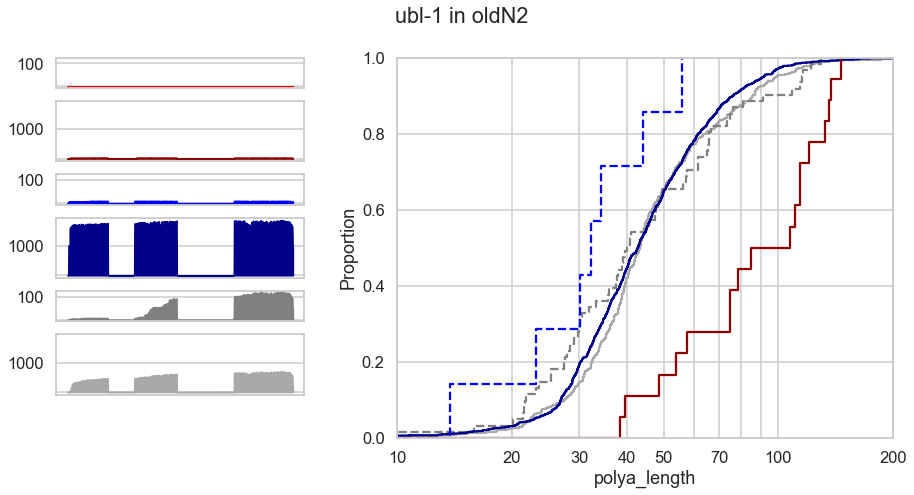

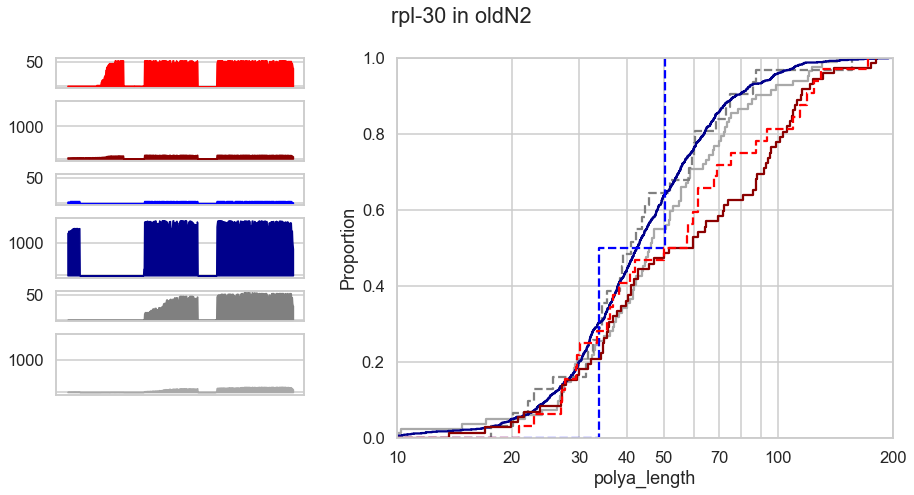

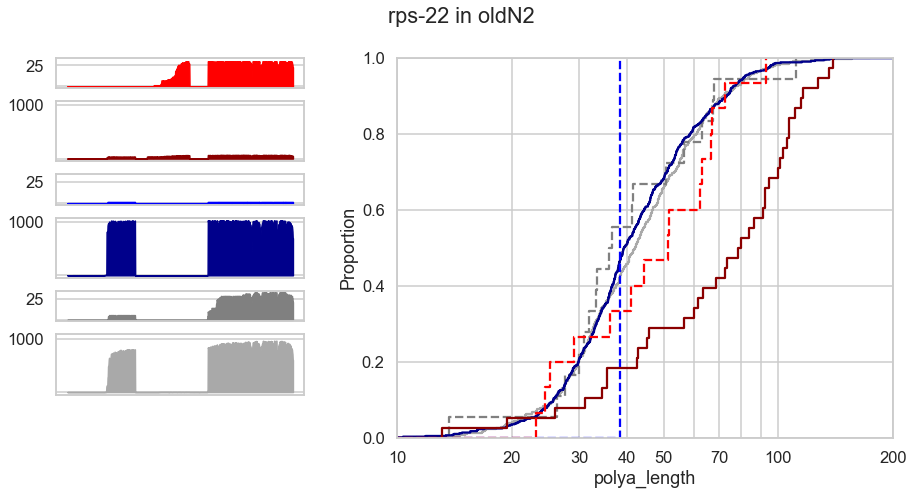

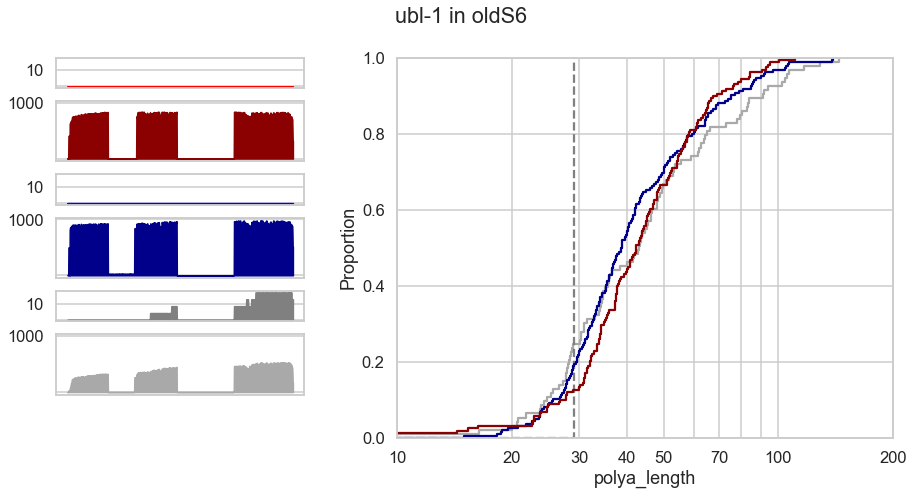

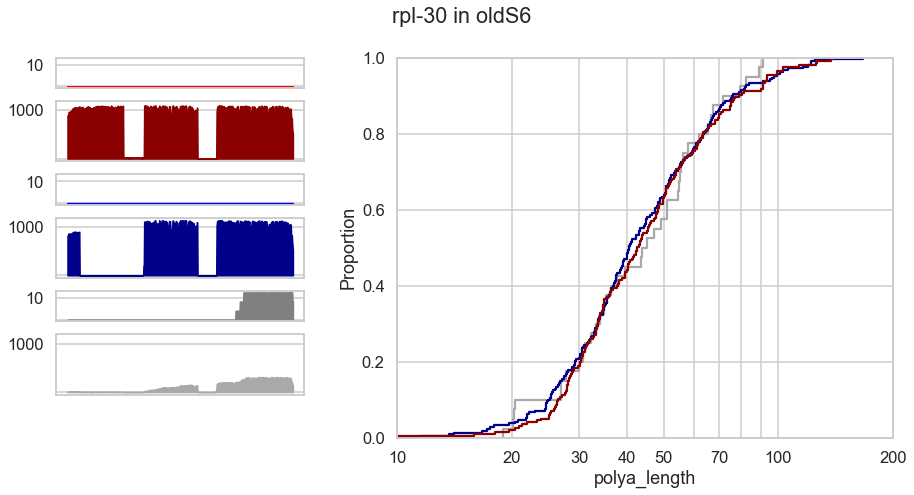

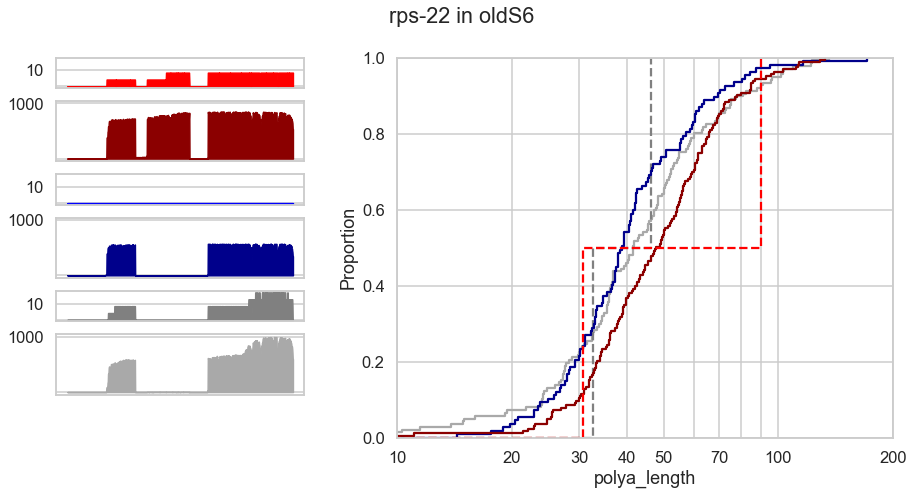

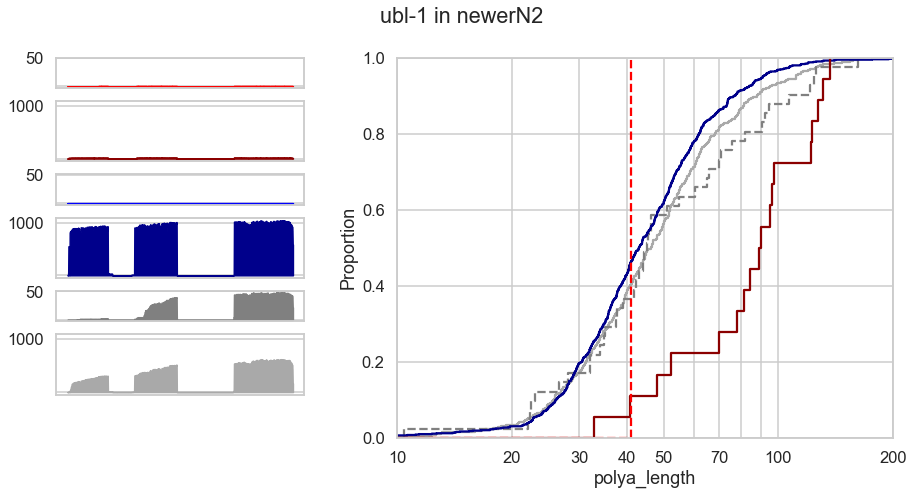

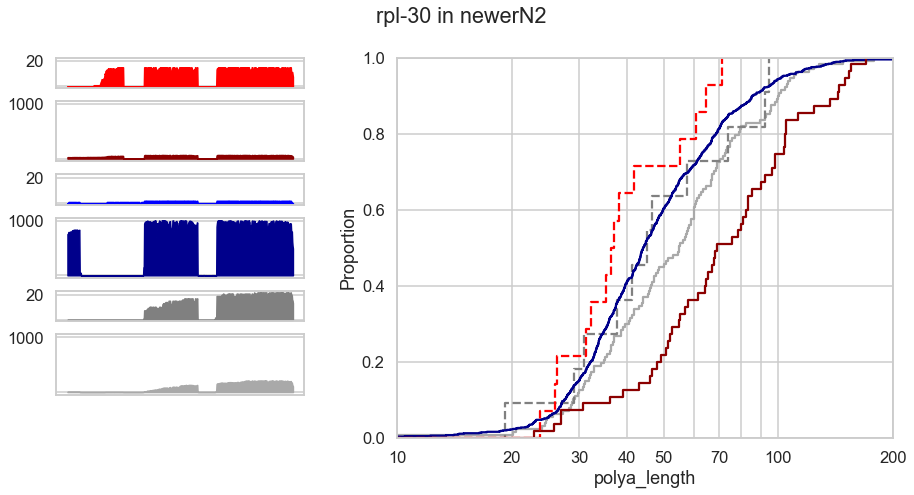

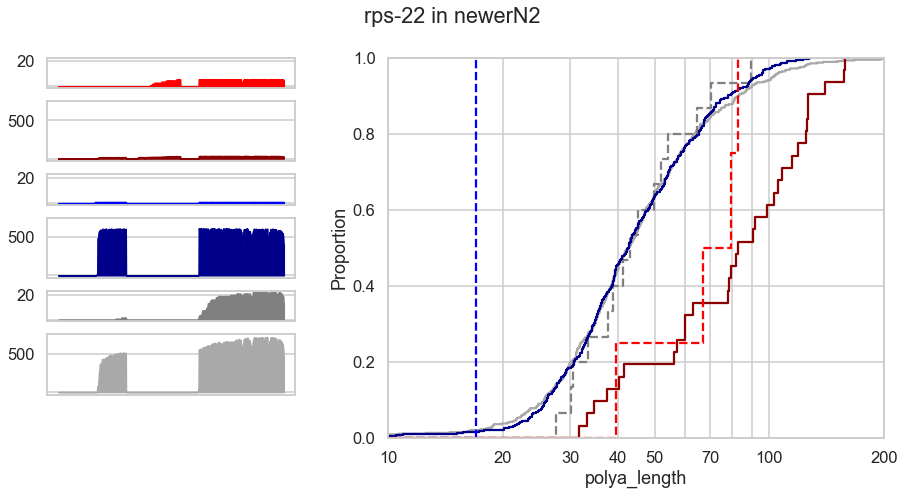

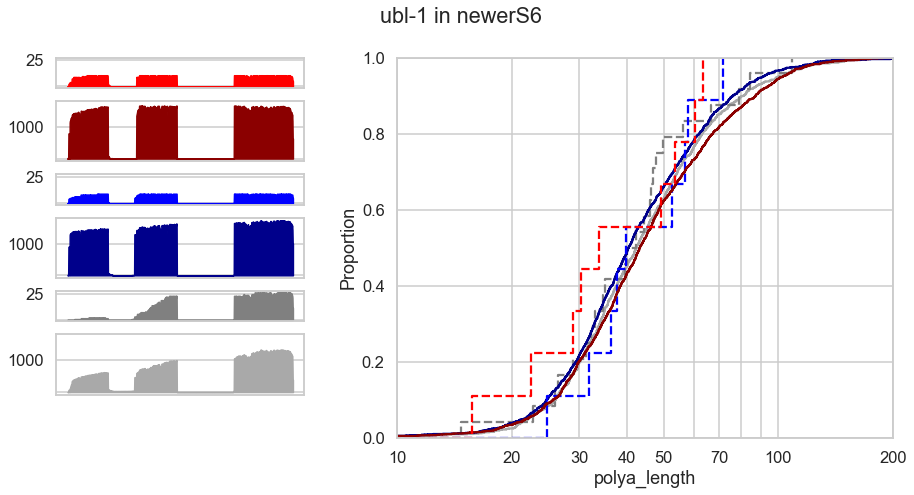

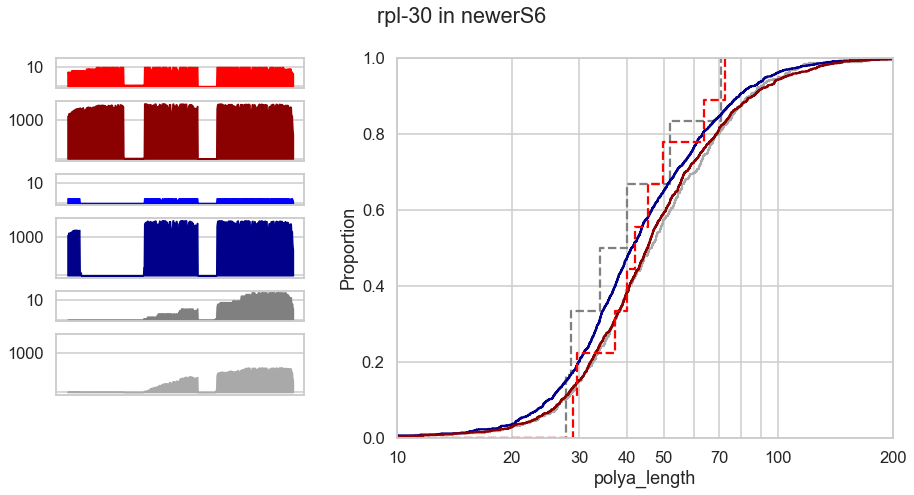

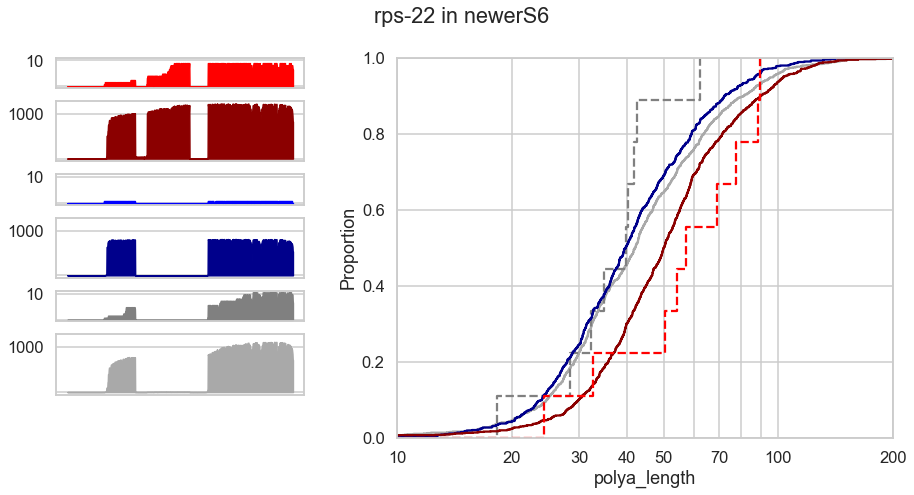

In [5]:
libraries = (
    'oldN2',
    'oldS6',
    # 'newN2',
    # 'newS6',
    # 'newS5',
    'newerN2',
    'newerS6',
)

target_genes = (
    'ubl-1',
    'rpl-30',
    'rps-22'
)

for library in libraries:
    for gene_to_plot in target_genes:
        lib_df = reads_df_raw.copy(deep=True).query(f"lib == '{library}'")  #.sample(10000)
        plot_tails_and_coverage(lib_df,
                                gene_to_plot,
                                library,
                                save_dir=f"/home/marcus/Insync/marcus.viscardi@gmail.com/Google Drive/insync_folder/5TERA_ReadsAndTails_Plots/raw_figures_from_python/{npCommon.get_dt()}_coverageAndTails_{'-'.join(libraries)}_{'-'.join(target_genes)}",
                                quiet=True,
                                log_tails=True,
                                ecdf_tails=True,
                                )

# Assessing the results:

Generally, I think this worked really well. There are some details holding it back from being perfect:
1. I think the tail plot section needs to be a bit wider to emphasize the difference between all of these different statuses.
2. For genes like rps-22 that have a lot of very similar isoforms, there are a bunch of reads dropping into the "ambiguous" category. This is not because they are not obviously the NMD isoform or not, but rather they are multiply mapping to the OTHER isoforms and failing to get a singular "best" map.
3. Still need to be able to plot the isoforms!! but inkscape will continue to work for this... I guess... lol

***
# Tail Scatter plots

The goal for this is to produce two scatter plots for each *smg-5* and *smg-6*. These plots will be:
1. WT full length NMD isoform polyA tails vs. WT deg. Intermediate NMD isoform polyA tails
2. WT full length NMD isoform polyA tails vs. *smg-6*/*smg-5* full length NMD isoform polyA tails

***

I think I can produce a version of "plot 2" with the curated list from above fairly quickly. If I decide to use a less stringent list in the future I can just add that to this code!

The main problem with "plot 1" is that I'll need to decide what degradation intermediates to call NMD derived when the necessary isoform information is gone! Some options:

1. Just call all degradation intermediates NMD derived (very content, but could mask signal?)
2. Call all ambiguous deg. intermediates NMD derived (less consistent but ensures that I am not adding decapped reads)

***

For now, I'll get "plot 2" working, then circle back to figure this all out.

Going to produce tail scatter plot with these 11 genes:
    rpl-30, rpl-26, rpl-3, rpl-1, rpl-12, ubl-1, rps-22, odc-1, hel-1, K08D12.3, aly-3
Plotting tail scatter for libraries oldN2 & newerN2:
Only 27792 of 1754865 (1.58%) reads are within the curated list of NMD genes.


Identifying reads as NMD-target, non-target, or ambiguous:   0%|          | 0/27792 [00:00<?, ?it/s]

N2
Saving figure to /home/marcus/Insync/marcus.viscardi@gmail.com/Google Drive/insync_folder/5TERA_ReadsAndTails_Plots/raw_figures_from_python/230403_tailScatters/newerN2-oldN2_tailScatter_wSEM.svg
Saving figure to /home/marcus/Insync/marcus.viscardi@gmail.com/Google Drive/insync_folder/5TERA_ReadsAndTails_Plots/raw_figures_from_python/230403_tailScatters/newerN2-oldN2_tailScatter_wSEM.png


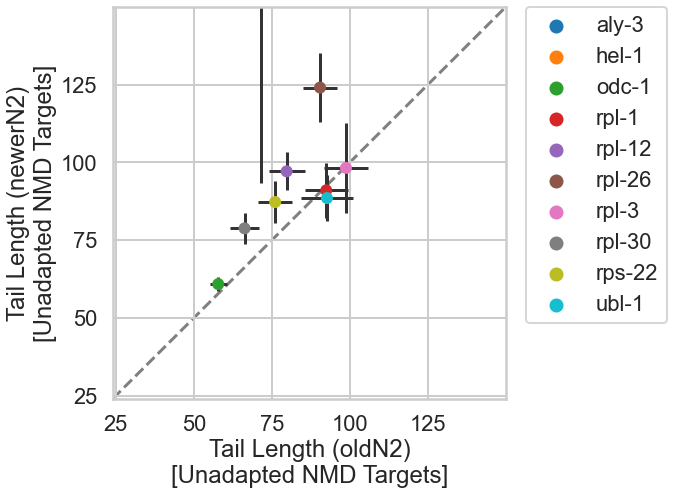

Plotting tail scatter for libraries oldS6 & newerS6:
Only 41905 of 1462430 (2.87%) reads are within the curated list of NMD genes.


Identifying reads as NMD-target, non-target, or ambiguous:   0%|          | 0/41905 [00:00<?, ?it/s]

S6
Saving figure to /home/marcus/Insync/marcus.viscardi@gmail.com/Google Drive/insync_folder/5TERA_ReadsAndTails_Plots/raw_figures_from_python/230403_tailScatters/newerS6-oldS6_tailScatter_wSEM.svg
Saving figure to /home/marcus/Insync/marcus.viscardi@gmail.com/Google Drive/insync_folder/5TERA_ReadsAndTails_Plots/raw_figures_from_python/230403_tailScatters/newerS6-oldS6_tailScatter_wSEM.png


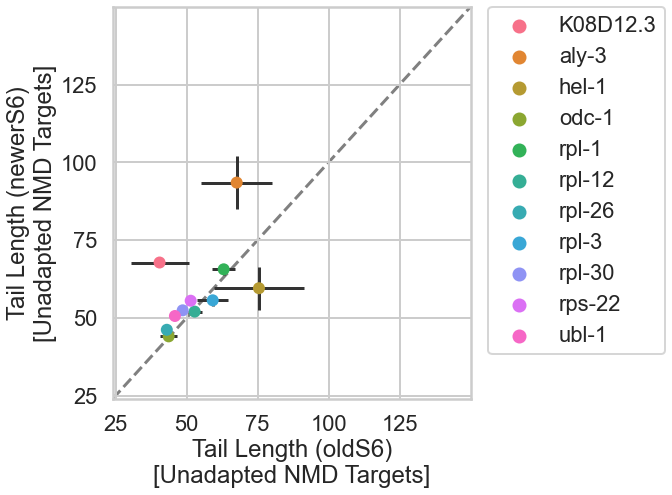

In [7]:
target_lib_sets = (# ('oldN2', 'oldS6'),
                   # ('newN2', 'newS5'),
                   # ('newN2', 'newS6'),
                   # ('newS5', 'newS6'),
                   # ('oldS6', 'newS6'),
                   ('oldN2', 'newerN2'),
                   ('oldS6', 'newerS6'),
                   )

save_dir = f"/home/marcus/Insync/marcus.viscardi@gmail.com/Google Drive/insync_folder/5TERA_ReadsAndTails_Plots/raw_figures_from_python/{npCommon.get_dt()}_tailScatters"

targets_and_iso_edge_dictionary = TARGETS_AND_ISOEDGE_DICT
direction_to_comparator = {'left': ("<=", ">="),
                           'right': (">=", "<=")}

def _apply_per_gene_adjustments(gene_name=None, transcript_id=None,
                                t5=None, chr_pos=None, call_adapted_species_NMD_derived=False,
                                **other_kwargs):
        try:
            iso_edge, left_or_right, NMD_sensitive_txns = targets_and_iso_edge_dictionary[gene_name]
            comparator, anti_comparator = direction_to_comparator[left_or_right]
        except KeyError:
            print(f"Currently only these genes have the necessary information for this full analysis:\n {list(targets_and_iso_edge_dictionary.keys())}\n You should try to filter your dataframe before running this function")
            from pprint import pprint
            print(gene_name)
            dir_values = {key: eval(key) for key in dir()}
            pprint(dir_values)
            raise KeyError
        
        if transcript_id in NMD_sensitive_txns:
            NMD_sensitive_isoform = '+'
        else:
            NMD_sensitive_isoform = '-'
        
        chr_position = chr_pos  # This is used in the below evaluate function
        if t5 == '+' and eval(f"chr_position {anti_comparator} {iso_edge}"):
            NMD_sensitive_isoform = '~'
        if not transcript_id:
            NMD_sensitive_isoform = '~'
        
        if call_adapted_species_NMD_derived and t5 == '+':
            NMD_sensitive_isoform = '+'
        
        NMD_and_t5 = f"NMD'ed: {NMD_sensitive_isoform}  t5: {t5}"
        
        return NMD_sensitive_isoform, NMD_and_t5


def plot_tails_scatter(input_df, save_directory=None, split_column='lib',
                       flip_split_col_order=True, fill_na=False,
                       plot_limits=(0, 150), plot_line_step=25) -> pd.DataFrame:
    
    split_col_values = input_df[split_column].unique().tolist()
    num_split_col_values = len(split_col_values)
    
    if num_split_col_values != 2:
        raise NotImplementedError(f"You provided a dataframe with {num_split_col_values} unique values in the split column ({', '.join(split_col_values)}), please only provide two. This will allow the values to be plotted!")
    if flip_split_col_order:
        y_val, x_val = split_col_values
    else:
        x_val, y_val = split_col_values
    
    groupby = input_df.groupby([split_column, "gene_name"])
    new_df = pd.DataFrame()
    new_df['mean_tail'] = groupby['polya_length'].mean()
    new_df['error'] = groupby['polya_length'].sem()  # standard error of the mean
    new_df['counts'] = groupby['polya_length'].count()
    new_df = long_to_wide(new_df,
                          wide_target_cols=['mean_tail', 'error', 'counts'],
                          expand_col=split_column,
                          fillna=fill_na)
    sea.set_style("whitegrid")
    sea.set_context('poster')
    plt.figure(figsize=(10, 7.4))
    
    # ###
    # print(new_df)
    # 
    # import matplotlib.patches
    # 
    # levels, categories = pd.factorize(new_df['gene_name'])
    # print(levels, categories)
    # colors = {gene_name: plt.cm.tab10(i) for i, gene_name in enumerate(categories)} # using the "tab10" colormap
    # handles = [matplotlib.patches.Patch(color=plt.cm.tab10(i), label=c) for i, c in enumerate(categories)]
    # ###
    sea.scatterplot(new_df,
                    x=f'mean_tail_{x_val}',
                    y=f'mean_tail_{y_val}',
                    hue='gene_name',
                    linewidth=0,
                    zorder=2,
                    )
    plt.errorbar(x=new_df[f'mean_tail_{x_val}'],
                 xerr=new_df[f'error_{x_val}'],
                 y=new_df[f'mean_tail_{y_val}'],
                 yerr=new_df[f'error_{y_val}'],
                 fmt='.',
                 c='0.2',
                 zorder=1,
                 )
    
    min_plot, max_plot = plot_limits
    plt.plot([min_plot-1, max_plot],
             [min_plot-1, max_plot],
             c='0.5',
             linestyle='dashed',
             zorder=0)
    plt.xlim(min_plot-1, max_plot)
    plt.ylim(min_plot-1, max_plot)
    plt.xticks(range(min_plot, max_plot, plot_line_step))
    plt.yticks(range(min_plot, max_plot, plot_line_step))
    
    if x_val.endswith("N2") or y_val.endswith("N2") or x_val[-2:] == y_val[-2:]:
        print(x_val[-2:])
        plt.xlabel(f'Tail Length ({x_val})\n[Unadapted NMD Targets]')
        plt.ylabel(f'Tail Length ({y_val})\n[Unadapted NMD Targets]')
        additional_save_file_tag = ""
    else:
        plt.xlabel(f'Tail Length ({x_val})')
        plt.ylabel(f'Tail Length ({y_val})')
        passed_libraries = input_df.lib.unique().tolist()
        if len(passed_libraries) == 1:
            additional_save_file_tag = f"{passed_libraries[0]}_"
        else:
            additional_save_file_tag = f"{'-'.join(passed_libraries)}_"
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.tight_layout()
    
    if save_directory:
        save_dir_path = Path(save_directory)
        if not save_dir_path.exists():
            save_dir_path.mkdir()
        gene_list_path = save_dir_path / 'plotted_gene_list.txt'
        if not gene_list_path.exists():
            with open(gene_list_path, 'w') as f:
                f.write('\n'.join(TARGETS_AND_ISOEDGE_DICT.keys()))
        for file_type in ('.svg', '.png'):
            save_path = save_directory + f"/{y_val}-{x_val}_{additional_save_file_tag}tailScatter_wSEM" + file_type
            plt.savefig(save_path)
            print(f"Saving figure to {save_path}")
    else:
        print(f"Not saving figure to file...")
    plt.show()
    return new_df


nmd_sensitive_genes = list(targets_and_iso_edge_dictionary.keys())
print(f"Going to produce tail scatter plot with these {len(nmd_sensitive_genes)} genes:\n    {', '.join(nmd_sensitive_genes)}")

for lib_set in target_lib_sets:
    lib1, lib2 = lib_set
    print(f"Plotting tail scatter for libraries {lib_set[0]} & {lib_set[1]}:")
    lib_set_df = reads_df_raw[reads_df_raw.lib.isin(lib_set)].copy(deep=True)
    lib_set_read_count = lib_set_df.shape[0]
    
    lib_set_df = lib_set_df[lib_set_df.gene_name.isin(nmd_sensitive_genes)]
    curated_genes_read_count = lib_set_df.shape[0]
    
    print(f"Only {curated_genes_read_count} of {lib_set_read_count} ({curated_genes_read_count/lib_set_read_count:2.2%}) reads are within the curated list of NMD genes.")
    
    tqdm.pandas(desc="Identifying reads as NMD-target, non-target, or ambiguous")
    lib_set_df[['NMD_sensitive_isoform', 'NMD_and_t5']] = lib_set_df.progress_apply(lambda row: _apply_per_gene_adjustments(**row), axis=1, result_type='expand')
    
    lib_set_full_length_target_df = lib_set_df.query("""NMD_and_t5 == "NMD'ed: +  t5: -" """)
    # print(lib_set_full_length_target_df)
    plot_tails_scatter(lib_set_full_length_target_df, save_directory=save_dir,
                       plot_limits=(25, 150), plot_line_step=25,
                       )

## ***I NEED MORE EXAMPLE GENES!!***

# Make the WT unadapted vs WT adapted scatter plot next:

I'll scrape a bunch of the same processing code then just change what is plotted

The code currently works, but the analysis is FLAWED. This is because of the high number of ambiguous reads not making it into this! (This is one of the main problems I noted up above)

My current solution is going to be calling ALL adapted species NMD-targeted... This is mad hacky, but it will work for now.

Only 14300 of 701680 (2.04%) reads are within the curated list of NMD genes.


Identifying reads as NMD-target, non-target, or ambiguous:   0%|          | 0/14300 [00:00<?, ?it/s]

Saving figure to /home/marcus/Insync/marcus.viscardi@gmail.com/Google Drive/insync_folder/5TERA_ReadsAndTails_Plots/raw_figures_from_python/230403_tailScatters/NMD'ed: +  t5: +-NMD'ed: +  t5: -_oldN2_tailScatter_wSEM.svg
Saving figure to /home/marcus/Insync/marcus.viscardi@gmail.com/Google Drive/insync_folder/5TERA_ReadsAndTails_Plots/raw_figures_from_python/230403_tailScatters/NMD'ed: +  t5: +-NMD'ed: +  t5: -_oldN2_tailScatter_wSEM.png


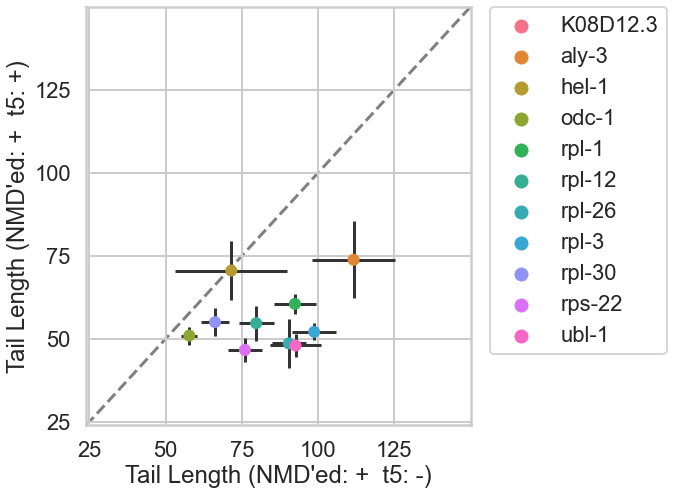

Saving figure to /home/marcus/Insync/marcus.viscardi@gmail.com/Google Drive/insync_folder/5TERA_ReadsAndTails_Plots/raw_figures_from_python/230403_tailScatters/NMD'ed: +  t5: +-NMD'ed: -  t5: -_oldN2_tailScatter_wSEM.svg
Saving figure to /home/marcus/Insync/marcus.viscardi@gmail.com/Google Drive/insync_folder/5TERA_ReadsAndTails_Plots/raw_figures_from_python/230403_tailScatters/NMD'ed: +  t5: +-NMD'ed: -  t5: -_oldN2_tailScatter_wSEM.png


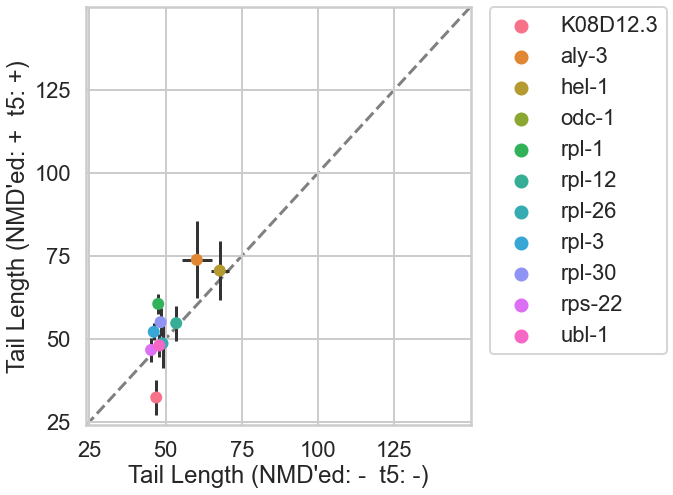

Only 13492 of 1053185 (1.28%) reads are within the curated list of NMD genes.


Identifying reads as NMD-target, non-target, or ambiguous:   0%|          | 0/13492 [00:00<?, ?it/s]

Saving figure to /home/marcus/Insync/marcus.viscardi@gmail.com/Google Drive/insync_folder/5TERA_ReadsAndTails_Plots/raw_figures_from_python/230403_tailScatters/NMD'ed: +  t5: +-NMD'ed: +  t5: -_newerN2_tailScatter_wSEM.svg
Saving figure to /home/marcus/Insync/marcus.viscardi@gmail.com/Google Drive/insync_folder/5TERA_ReadsAndTails_Plots/raw_figures_from_python/230403_tailScatters/NMD'ed: +  t5: +-NMD'ed: +  t5: -_newerN2_tailScatter_wSEM.png


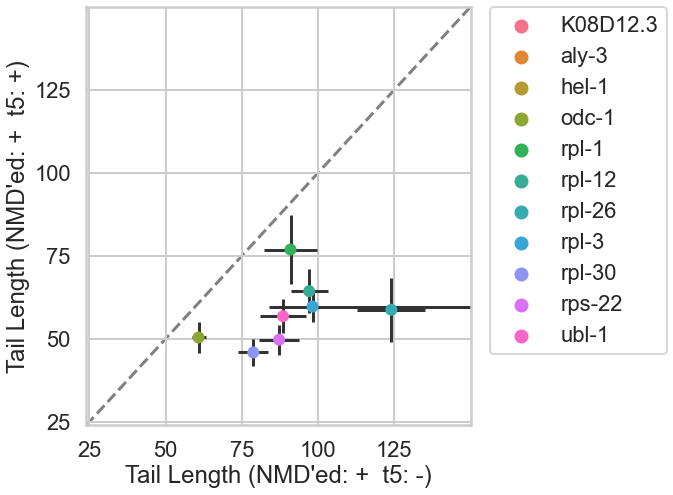

Saving figure to /home/marcus/Insync/marcus.viscardi@gmail.com/Google Drive/insync_folder/5TERA_ReadsAndTails_Plots/raw_figures_from_python/230403_tailScatters/NMD'ed: +  t5: +-NMD'ed: -  t5: -_newerN2_tailScatter_wSEM.svg
Saving figure to /home/marcus/Insync/marcus.viscardi@gmail.com/Google Drive/insync_folder/5TERA_ReadsAndTails_Plots/raw_figures_from_python/230403_tailScatters/NMD'ed: +  t5: +-NMD'ed: -  t5: -_newerN2_tailScatter_wSEM.png


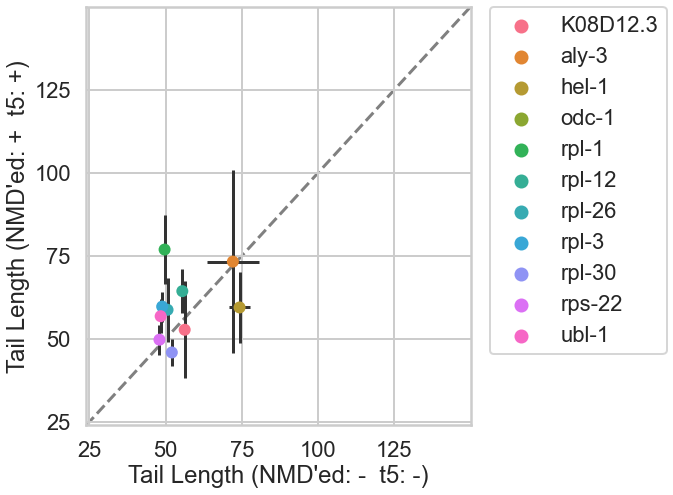

Only 36793 of 1226144 (3.00%) reads are within the curated list of NMD genes.


Identifying reads as NMD-target, non-target, or ambiguous:   0%|          | 0/36793 [00:00<?, ?it/s]

Saving figure to /home/marcus/Insync/marcus.viscardi@gmail.com/Google Drive/insync_folder/5TERA_ReadsAndTails_Plots/raw_figures_from_python/230403_tailScatters/NMD'ed: +  t5: --NMD'ed: +  t5: +_newerS6_tailScatter_wSEM.svg
Saving figure to /home/marcus/Insync/marcus.viscardi@gmail.com/Google Drive/insync_folder/5TERA_ReadsAndTails_Plots/raw_figures_from_python/230403_tailScatters/NMD'ed: +  t5: --NMD'ed: +  t5: +_newerS6_tailScatter_wSEM.png


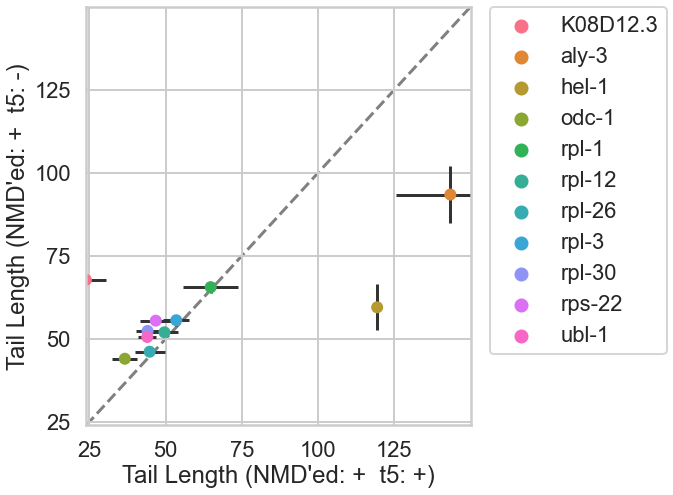

Saving figure to /home/marcus/Insync/marcus.viscardi@gmail.com/Google Drive/insync_folder/5TERA_ReadsAndTails_Plots/raw_figures_from_python/230403_tailScatters/NMD'ed: +  t5: +-NMD'ed: -  t5: -_newerS6_tailScatter_wSEM.svg
Saving figure to /home/marcus/Insync/marcus.viscardi@gmail.com/Google Drive/insync_folder/5TERA_ReadsAndTails_Plots/raw_figures_from_python/230403_tailScatters/NMD'ed: +  t5: +-NMD'ed: -  t5: -_newerS6_tailScatter_wSEM.png


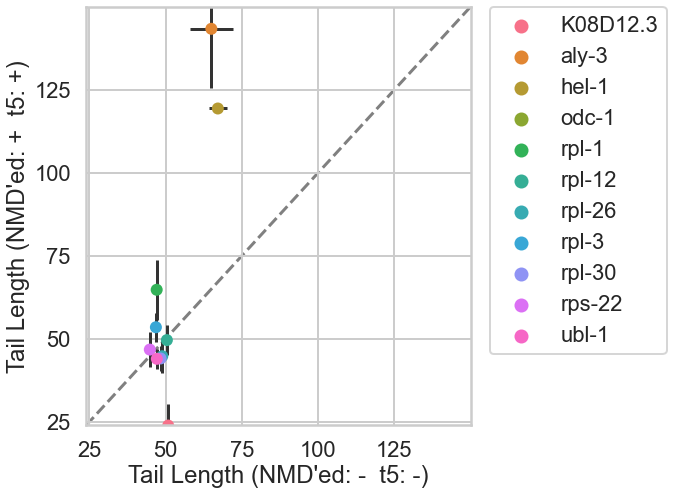

In [8]:
target_libraries = ('oldN2', 'newerN2', 'newerS6')
NMD_and_t5s_to_compare = (("NMD'ed: +  t5: -", "NMD'ed: +  t5: +"),
                          ("NMD'ed: -  t5: -", "NMD'ed: +  t5: +"),
                          )
for target_library in target_libraries:
    lib_df = reads_df_raw[reads_df_raw.lib == target_library].copy(deep=True)
    lib_read_count = lib_df.shape[0]
    lib_df = lib_df[lib_df.gene_name.isin(nmd_sensitive_genes)]
    curated_genes_read_count = lib_df.shape[0]
    
    print(f"Only {curated_genes_read_count} of {lib_read_count} ({curated_genes_read_count/lib_read_count:2.2%}) reads are within the curated list of NMD genes.")
    
    tqdm.pandas(desc="Identifying reads as NMD-target, non-target, or ambiguous")
    lib_df[['NMD_sensitive_isoform', 'NMD_and_t5']] = lib_df.progress_apply(lambda row: _apply_per_gene_adjustments(call_adapted_species_NMD_derived=True, **row), axis=1, result_type='expand')
    for i, NMD_and_t5_to_compare in enumerate(NMD_and_t5s_to_compare):
        plot_df = lib_df[lib_df.NMD_and_t5.isin(NMD_and_t5_to_compare)]
        if i == 0: flip = True
        else: flip = False
        plot_tails_scatter(plot_df, split_column="NMD_and_t5", fill_na=True,
                           flip_split_col_order=flip, save_directory=save_dir,
                           plot_limits=(25, 150), plot_line_step=25,
                           )